## HW 5 
## Grant Ovsepyan

Q1-1
Create a preprocess pipeline that conducts the usual data engineering steps (as in the lecture), and also create an outcome column that indicates which of the 5 categories the record belongs to.

In [1]:

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()
        self.attack_mapping = {
            "normal": 0,
            "DoS": 1,
            "Probe": 2,
            "U2R": 3,
            "R2L": 4,
             # assuming 'normal' is a category, if not, remove this line
        }
        
    def manual_category_indexing(self, category):
        # This function will be used in the UDF to convert category names to your hardcoded indices
        return self.attack_mapping.get(category, -1)  # returns -1 if the category is not found


    def _transform(self, dataset):
        # Define the attack groups
        group_dos = ["apache2", "back", "land", "neptune", "mailbomb", "pod", "processtable", "smurf", "teardrop", "udpstorm", "worm"]
        group_probe = ["ipsweep", "mscan", "nmap", "portsweep", "saint", "satan"]
        group_u2r = ["buffer_overflow", "loadmodule", "perl", "ps", "rootkit", "sqlattack", "xterm"]
        group_r2l = ["ftp_write", "guess_passwd", "httptunnel", "imap", "multihop", "named", "phf", "sendmail", "Snmpgetattack", "spy", "snmpguess", "warezclient", "warezmaster", "xlock", "xsnoop"]
        
        
        
        
        # UDF to categorize based on group membership
        def categorize_class(name):
            if name in group_dos:
                return "DoS"
            elif name in group_probe:
                return "Probe"
            elif name in group_u2r:
                return "U2R"
            elif name in group_r2l:
                return "R2L"
            else:
                return "normal"

        categorize_class_udf = udf(categorize_class, StringType())
        
        # Apply the categorization UDF to create a new column 'outcome'
        intermediate_df = dataset.withColumn('outcome', categorize_class_udf(col('class')))

        # Dropping the original 'class' and 'difficulty' columns as they're not needed
        intermediate_df = intermediate_df.drop('class', 'difficulty')

        # Now we'll use the manually defined mappings instead of StringIndexer
        manual_indexing_udf = udf(self.manual_category_indexing, IntegerType())

        # Create a new column 'outcome_indexed' that contains the mapped values
        final_df = intermediate_df.withColumn('outcome_indexed', manual_indexing_udf(col('outcome')))
        final = final_df.drop("outcome").withColumnRenamed("outcome_indexed", "outcome")
        
        
        
        # If you don't want to keep the original 'outcome' column with string values, you can drop it
        # final_df = final_df.drop('outcome')

        # Return the transformed DataFrame
        return final
    
class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [ ]:
!python -m wget https://www.andrew.cmu.edu/user/mfarag/14763/KDDTrain+.txt

In [ ]:
!python -m wget https://www.andrew.cmu.edu/user/mfarag/14763/KDDTest+.txt

In [ ]:
!pwd

In [2]:
# if you installed Spark on windows, 
# you may need findspark and need to initialize it prior to being able to use pyspark
# Also, you may need to initialize SparkContext yourself.
# Uncomment the following lines if you are using Windows!
#import findspark
#findspark.init()
#findspark.find()
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType



import os
import sys

# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SystemsToolChains") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('KDDTest+.txt',header=False).toDF(*col_names)



preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)






Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/26 12:58:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/26 12:58:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
nslkdd_df.printSchema()
nslkdd_df.show(100)


root
 |-- features: vector (nullable = true)
 |-- outcome: integer (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[1,13,14,17,...|      0|
|(113,[1,13,14,17,...|      0|
|(113,[13,14,15,17...|      1|
|(113,[1,2,13,14,1...|      0|
|(113,[1,2,13,14,1...|      0|
|(113,[13,14,16,17...|      1|
|(113,[13,14,15,17...|      1|
|(113,[13,14,15,17...|      1|
|(113,[13,14,15,17...|      1|
|(113,[13,14,15,17...|      1|
|(113,[13,14,16,17...|      1|
|(113,[13,14,15,17...|      1|
|(113,[1,2,13,14,1...|      0|
|(113,[1,13,14,17,...|      4|
|(113,[13,14,15,18...|      1|
|(113,[13,14,15,17...|      1|
|(113,[1,2,13,14,1...|      0|
|(113,[1,13,14,17,...|      2|
|(113,[1,2,13,14,1...|      0|
|(113,[1,2,13,14,1...|      0|
|(113,[13,14,15,17...|      1|
|(113,[13,14,15,17...|      1|
|(113,[1,2,13,14,1...|      0|
|(113,[0,1,2,13,14...|      0|
|(113,[13,14,15,17...|      1|
|(113,[0,1,2,7,11,...|      0|
|(113,[13,14,15

In [4]:
nslkdd_df_test.printSchema()
nslkdd_df_test.show(1)

root
 |-- features: vector (nullable = true)
 |-- outcome: integer (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[13,14,16,17...|      1|
+--------------------+-------+
only showing top 1 row



Q1-2 (20%) Select 2 machine learning models. For each of the machine learning models, train it on the training dataset. Calculate the train and test accuracy, and plot the confusion matrix (for the predictions on the test dataset).

DecisionTreeRegressor model

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
# Model 2 - decision tree
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="outcome")
decModel = dt.fit(nslkdd_df)
dec_predictions = decModel.transform(nslkdd_df_test)


result_temp = dec_predictions.select('outcome', 'prediction').toPandas()

# train and test accuracy
dec_predictions_train = decModel.transform(nslkdd_df)# predictions using the training dataset
accuracy_train = (dec_predictions_train.filter(dec_predictions_train.outcome == dec_predictions_train.prediction)
    .count() / float(dec_predictions_train.count()))

accuracy_test = (dec_predictions.filter(dec_predictions.outcome == dec_predictions.prediction)
    .count() / float(dec_predictions.count()))
print(f"Train Accuracy : {np.round(accuracy_train*100,2)}%")
print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")





Train Accuracy : 98.02%
Test Accuracy : 74.26%


In [8]:
dec_predictions.printSchema()  # Check the types of the 'outcome' and 'prediction' columns


root
 |-- features: vector (nullable = true)
 |-- outcome: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



Since we can't make confusion matrix for all types of attack, we will create a binary onfusion matrix for each type of the attack separately

Confusion matrix, without normalization
[[9626   72  191    0    0]
 [1482 5852  126    0    0]
 [ 688  470 1263    0    0]
 [  60    7    0    0    0]
 [2698    5    4    0    0]]


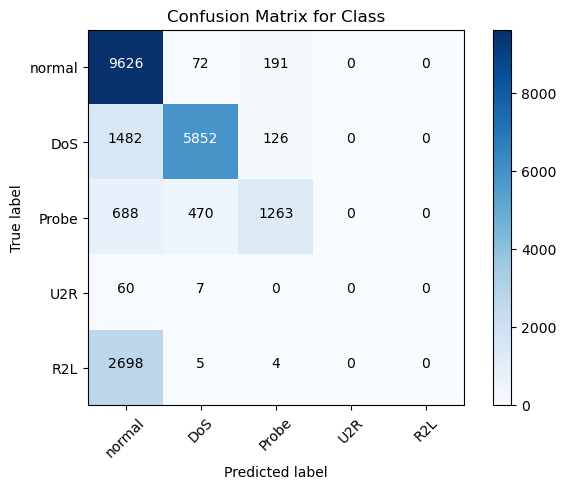

In [9]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd


labels = [0, 1.0, 2.0, 3.0, 4.0]

cnf_matrix = confusion_matrix(result_temp['outcome'], result_temp['prediction'], labels=labels)

label_names = ["normal", "DoS", "Probe", "U2R", "R2L"]




plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_names, title=f'Confusion Matrix for Class')
plt.show()
    





Random forest classifier



[Stage 47:==============================================>           (4 + 1) / 5]



Test Accuracy: 75.27%
Train Accuracy: 97.86%
Confusion matrix, without normalization
[[9664   54  171    0    0]
 [1503 5953    4    0    0]
 [ 799  271 1351    0    0]
 [  67    0    0    0    0]
 [2672    0   35    0    0]]


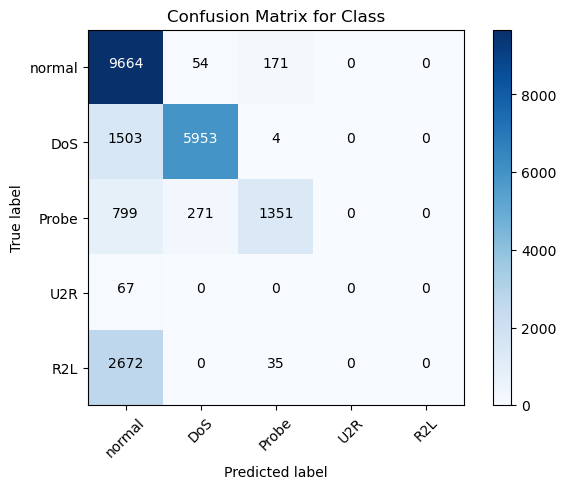

In [10]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='outcome', numTrees=10)
rfModel = rf.fit(nslkdd_df)
predictions = rfModel.transform(nslkdd_df_test)
evaluator = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy")
accuracy_test = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")

predictions_train = rfModel.transform(nslkdd_df)
accuracy_train = evaluator.evaluate(predictions_train)
print(f"Train Accuracy: {accuracy_train * 100:.2f}%")
pd_predictions = predictions.select('outcome', 'prediction').toPandas()

unique_classes = pd_predictions['outcome'].unique()
labels = [0, 1.0, 2.0, 3.0, 4.0]
cnf_matrix = confusion_matrix(pd_predictions['outcome'], pd_predictions['prediction'], labels=labels)
label_names = ["normal", "DoS", "Probe", "U2R", "R2L"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_names, title=f'Confusion Matrix for Class')
plt.show()

Q1-3 For each of the 2 machine learning models, identify at least one hyper parameter, build a parameter grid and conduct hyper-parameter tuning using cross- validation, with accuracy as the metric. Calculate the test accuracy after tuning. (Hint: for evaluating accuracy, the you may need to find the appropriate Evaluator with the appropriate metric name).

Hyperparameter tuning for DecisionTreeRegressor model

In [22]:
print(f"Test Accuracy before hyperparameter tuning : {np.round(accuracy_test*100,2)}%")

Test Accuracy before hyperparameter tuning : 75.27%


In [20]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define the DecisionTreeClassifier model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='outcome')

# Define a MulticlassClassificationEvaluator for evaluating the model performance
evaluator = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy")

# Define the parameter grid for cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [ 10, 20]) \
    .addGrid(dt.maxBins, [ 60, 80]) \
    .addGrid(dt.minInstancesPerNode, [ 2, 4]) \
    .build()

# Set up the CrossValidator for tuning
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5,  # Use 5 folds for cross-validation
                          seed=42)  # For reproducibility

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(nslkdd_df)

# Fetch the best model
bestModel = cvModel.bestModel

# Make predictions on the test data with the best model
predictions = bestModel.transform(nslkdd_df_test)

# Calculate the model's accuracy on the test data
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy}")

# Print out the best model's optimal parameters (you can print others as well)
print(f"Best Model - Max Depth: {bestModel.getMaxDepth()}")
print(f"Best Model - Max Bins: {bestModel.getMaxBins()}")
print(f"Best Model - Min Instances Per Node: {bestModel.getMinInstancesPerNode()}")


23/10/26 13:38:04 WARN CacheManager: Asked to cache already cached data.
23/10/26 13:38:04 WARN CacheManager: Asked to cache already cached data.


Test Accuracy: 0.8201295244854506
Best Model - Max Depth: 20
Best Model - Max Bins: 80
Best Model - Min Instances Per Node: 2


Hyperparameter tuning for RandomForestClassifier

In [21]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator  # Correct evaluator for classification
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession

# Assuming you have already created a SparkSession called spark

# Create and fit a default RandomForest model.
rf_default = RandomForestClassifier(featuresCol='features', labelCol='outcome')
rf_default_model = rf_default.fit(nslkdd_df)

# Make predictions with the default model
rf_default_predictions = rf_default_model.transform(nslkdd_df_test)

# Evaluator with accuracy metric
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="outcome", metricName="accuracy")

# Evaluate the default model using accuracy
accuracy_default = evaluator.evaluate(rf_default_predictions)
print("Accuracy for Default Random Forest: ", accuracy_default)

# Set up the RandomForest model for tuning
rf = RandomForestClassifier(featuresCol='features', labelCol='outcome')

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 30]) \
    .addGrid(rf.maxDepth, [4, 6, 8]) \
    .build()

# Cross-validation setup
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,  # Using the accuracy evaluator
                          numFolds=3)

# Fit the model with tuning
rf_cvModel = crossval.fit(nslkdd_df)

# Fetch the best model
best_rfModel = rf_cvModel.bestModel

# Make predictions with the tuned model
rf_cv_predictions = best_rfModel.transform(nslkdd_df_test)

# Evaluate the tuned model using accuracy
accuracy_tuned = evaluator.evaluate(rf_cv_predictions)
print("Accuracy for Random Forest after Cross-Validation: ", accuracy_tuned)


Accuracy for Default Random Forest:  0.7731103619588361
Accuracy for Random Forest after Cross-Validation:  0.774263662171753


Q1-4 In your own words, explain why you chose the two machine learning models, and for each of the two models, why you chose the hyper-parameters to tune, and how you designed the parameter grid. Also, please include a discussion on the comparison of the two models.

1. Choice of Machine Learning Models:

1. DecisionTreeRegressor Model:

Why this model was chosen:
Decision trees are versatile models that can handle both categorical and numerical data and are capable of fitting complex datasets. Using a DecisionTreeRegressor model is beneficial due to its interpretability; you can easily visualize and understand the decision path taken by the model for predictions. This is particularly useful if you need to explain the decision-making process to stakeholders.

Why these hyper-parameters were chosen for tuning:

maxDepth: This parameter determines how deep the tree can grow and is essential to prevent overfitting. A shallower tree (lower depth) might not capture the data complexities, whereas a deeper tree (higher depth) might capture too much noise and detail, causing overfitting.
maxBins: This parameter specifies the maximum number of bins used for splitting features. It affects how continuous features are handled and can impact the model's ability to learn fine-grained patterns.
minInstancesPerNode: This parameter sets the minimum number of instances each node must have after a split. Setting this value helps in regularizing the tree structure and preventing overfitting by ensuring that splits are made only when there's a sufficient sample size.
Parameter grid design:
The parameter grid you designed is a limited search space focusing on a few key hyperparameters that significantly impact the model's performance. You chose sensible defaults based on prior knowledge or preliminary experimentation, ensuring the model isn't too complex or too simple.

2. Random Forest Classifier:

Why this model was chosen:
Random forests are an ensemble learning method that operates by constructing multiple decision trees during training. They tend to correct decision trees' habit of overfitting to their training set. Random forests are chosen for their ability to deal with binary outcomes and their robustness to overfitting, given they average several trees' outcomes.

Why these hyper-parameters were chosen for tuning:

numTrees: This parameter indicates the number of trees in the forest. Increasing the number of trees generally improves accuracy but also results in longer training times. There's a threshold beyond which more trees don't significantly improve performance, so tuning this parameter helps find that balance.
maxDepth: Similar to the decision tree model, this parameter controls the depth of each tree. Tuning this parameter is critical for the same reasons: balancing bias and variance.
Parameter grid design:
Your grid provides a mix of depth and number of trees, which will significantly affect the model's complexity and, consequently, its ability to generalize. By experimenting with these in a controlled range, you aim to find a sweet spot where your model is complex enough to capture underlying patterns in the data but not so complex that it overfits.

Comparison of the two models:

Performance: Both models saw an improvement in test accuracy after hyperparameter tuning, indicating that the tuning was successful in finding a better configuration for each model. However, it's noteworthy that the DecisionTreeRegressor had a more substantial increase in performance compared to the Random Forest Classifier. One reason could be that the decision tree was initially overfitting the training set, and through tuning, it became more generalized, enhancing its test performance.
Overfitting: The Random Forest model shows less discrepancy between training and testing accuracy, both before and after tuning. This consistency suggests that the ensemble method is more robust against overfitting, as it averages multiple trees' decisions.
Interpretability vs. Accuracy: Decision trees generally offer better interpretability than random forests, but this often comes at the cost of accuracy. In contrast, random forests typically provide higher accuracy but are harder to interpret because predictions result from aggregating across many trees.


Q2-1 a) How does Gradient Boosted Tree work?
Gradient Boosted Trees (GBTs) are an ensemble learning method that builds trees sequentially: each tree is formed to correct the mistakes of the previous one, based on the gradient of the loss function. Specifically, GBTs use the principle of gradient descent to minimize the loss when adding new models. Each new tree estimates the error of the whole ensemble of earlier trees and tries to correct this error for the final prediction.

b) What are the pros and cons of Gradient Boosted Trees?

Pros:

Highly Accurate: GBTs often provide superior results due to their boosting stage, making them very effective for complex datasets where relationships between features and the target variable are non-linear.
Feature Relevance: GBTs offer a built-in feature importance estimation, helping identify which parts of the data are contributing most to the prediction.
Cons:

Prone to Overfitting: Without careful tuning of hyperparameters, GBTs can easily overfit to the training data, especially with noisy datasets.
Computationally Intensive: They require more computational resources and time to train, given the sequential building of trees. They also take longer to train than random forests due to the inability to parallelize tree construction fully.
c) Two hyper-parameters in Gradient Boosted Trees:

maxDepth: This parameter determines the maximum depth of each tree. Deeper trees are more expressive and can model more complex relationships by adding more decision nodes, but they are also more prone to overfitting. The depth is essentially a measure of how many splits the tree can make before making a prediction. In your grid, you're testing relatively shallow to moderate depths, aiming to keep the model's complexity in check while still allowing it to learn from the data.
maxBins: This is the maximum number of bins that can be used for splitting features. This parameter is used in handling continuous features and slightly affects the tree's growing process. Having more bins allows the algorithm to consider more split points and can lead to higher granularity models. However, increasing this number can also require more data to populate the bins effectively and may lead to overfitting if the dataset isn't large enough.
maxIter: This is the number of iterations, i.e., the number of trees to be built. Each iteration corresponds to a tree model that tries to correct the residuals (errors) of the combined ensemble of all previous trees. More iterations allow for more opportunities for the model to learn from the data, but after a certain point, there may be diminishing returns, and overfitting becomes a concern. By choosing different values for this parameter, you're balancing between underfitting and overfitting.
stepSize: Also known as the learning rate, this parameter scales the contribution of each tree to the final model. Smaller values make the model more robust to over-specificity, while larger ones can speed up the learning process but make it more prone to overfitting. By experimenting with different step sizes, you're trying to find a sweet spot where your model learns quickly and efficiently but isn't too sensitive to noise, nor too general.

Q2-2 need to change the pipeline since this is not a regresssion, but classification probelm

In [23]:

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0)
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [24]:
# if you installed Spark on windows, 
# you may need findspark and need to initialize it prior to being able to use pyspark
# Also, you may need to initialize SparkContext yourself.
# Uncomment the following lines if you are using Windows!
#import findspark
#findspark.init()
#findspark.find()

import os
import sys

# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SystemsToolChains") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)


In [25]:
nslkdd_df.printSchema()
nslkdd_df.show(50)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[1,13,14,17,...|    0.0|
|(113,[1,13,14,17,...|    0.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    1.0|
|(113,[13,14,15,18...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[0,1,2,13,14...|    0.0|
|(113,[13,14,15,17...|    1.0|
|(113,[0,1,2,7,11,...|    0.0|
|(113,[13,14,15,

In [26]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
gbt = GBTClassifier(labelCol="outcome", featuresCol="features", maxIter=10)  # You can adjust maxIter
gbt_model = gbt.fit(nslkdd_df)
train_predictions = gbt_model.transform(nslkdd_df)
test_predictions = gbt_model.transform(nslkdd_df_test)
correct_train = train_predictions.filter(train_predictions['outcome'] == train_predictions['prediction']).count()
total_train = train_predictions.count()
train_accuracy = correct_train / total_train

correct_test = test_predictions.filter(test_predictions['outcome'] == test_predictions['prediction']).count()
total_test = test_predictions.count()
test_accuracy = correct_test / total_test

print("Training set accuracy: ", 100*train_accuracy)
print("Test set accuracy: ", 100*test_accuracy)

Training set accuracy:  99.47845966992928
Test set accuracy:  77.96753016323635


Confusion matrix, without normalization
[[9437  274]
 [4693 8140]]
Normalized confusion matrix
[[0.97178457 0.02821543]
 [0.36569781 0.63430219]]


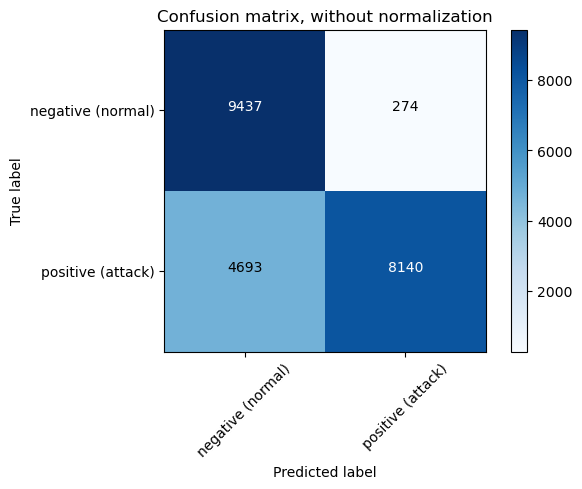

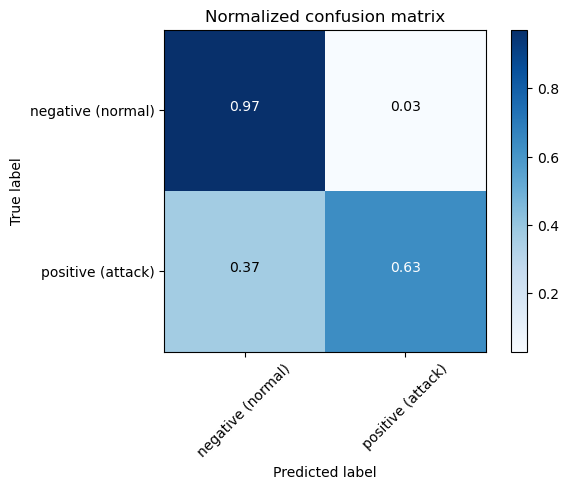

In [27]:
# create a confusion matrix
from pyspark.ml.classification import GBTClassifier

# Train model
gbt = GBTClassifier(labelCol="outcome", featuresCol="features", maxIter=10)
model = gbt.fit(nslkdd_df)

# Make predictions
predictions = model.transform(nslkdd_df_test)


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix






# Convert Spark DataFrame to Pandas
outcome_true_pandas = predictions.select("outcome").toPandas()
pred_pandas = predictions.select("prediction").toPandas()

# Labels
class_names=[0.0,1.0] # Assuming 0.0 is 'normal' and 1.0 is 'attack'
class_names_str=["negative (normal)","positive (attack)"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(outcome_true_pandas, pred_pandas, labels=class_names)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix (if required)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str, normalize=True, title='Normalized confusion matrix')

plt.show()


perfomr hyperparameter fine tuning

In [28]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 1. Train and evaluate the model using default parameters
gbt_default = GBTClassifier(labelCol="outcome", featuresCol="features")
model_default = gbt_default.fit(nslkdd_df)
predictions_default = model_default.transform(nslkdd_df_test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='outcome', metricName='areaUnderROC')
default_auc = evaluator.evaluate(predictions_default)

# Prepare score-label set
results_default = predictions_default.select(['probability', 'outcome'])

# Extracting the probability of class 1 (positive class)
get_class_one_proba = udf(lambda proba: float(proba[1]), FloatType())
results_default = results_default.withColumn("probability_class_1", get_class_one_proba("probability"))

# 2. Hyperparameter tuning using CrossValidator
gbt = GBTClassifier(labelCol="outcome", featuresCol="features")

# New parameter grid with more diverse options
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [4, 6, 8])  # Adjusted depths
             .addGrid(gbt.maxBins, [32, 48])  # Adjusted number of bins
             .addGrid(gbt.maxIter, [10, 20])  # Added iterations
             .addGrid(gbt.stepSize, [0.03, 0.05, 0.1])  # Added step sizes (learning rates)
             .build())

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(
                              rawPredictionCol='rawPrediction', 
                              labelCol='outcome', 
                              metricName='areaUnderROC'),
                          numFolds=3)  # Reduced to 3 folds due to the increased number of parameters


cvModel = crossval.fit(nslkdd_df)
predictions_tuned = cvModel.transform(nslkdd_df_test)
tuned_auc = evaluator.evaluate(predictions_tuned)

# Prepare score-label set for tuned model
results_tuned = predictions_tuned.select(['probability', 'outcome'])

# Extracting the probability for class 1 from tuned model predictions
results_tuned = results_tuned.withColumn("probability_class_1", get_class_one_proba("probability"))

# Now collect the results into NumPy arrays
y_true_default = np.array([row['outcome'] for row in results_default.collect()])
y_prob_default = np.array([row['probability_class_1'] for row in results_default.collect()])

y_true_tuned = np.array([row['outcome'] for row in results_tuned.collect()])
y_prob_tuned = np.array([row['probability_class_1'] for row in results_tuned.collect()])

# Calculate the ROC curve points for both default and tuned models
fpr_default, tpr_default, _ = roc_curve(y_true_default, y_prob_default)
fpr_tuned, tpr_tuned, _ = roc_curve(y_true_tuned, y_prob_tuned)




In [1]:
# Plotting the ROC Curves
plt.figure(figsize=(10,7))

# Creating labels without using the round function directly to avoid the conflict
label_default = 'After Tuning, AUC={:.2f}'.format(default_auc)
label_tuned = 'Before Tuning, AUC={:.2f}'.format(tuned_auc)

plt.plot(fpr_default, tpr_default, label=label_default, color='b')
plt.plot(fpr_tuned, tpr_tuned, label=label_tuned, color='g')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


NameError: name 'plt' is not defined